<h1><center> Group Assignment: Bird Classifier  </center></h1>

In [1]:
# Import PyTorch and supporting libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from PIL import Image

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available. Running on Apple GPU.")
else:
    print("MPS backend is not available. Running on CPU.")


MPS backend is available. Running on Apple GPU.


In [3]:
device = torch.device("mps")  # Use MPS for Apple Silicon
x = torch.tensor([1.0, 2.0, 3.0], device=device)
print("Tensor on MPS:", x)


Tensor on MPS: tensor([1., 2., 3.], device='mps:0')


In [41]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Load the CSV file
# train data
train_csv_path = "data/train_images.csv"
train_label_df = pd.read_csv(train_csv_path)

# test data
test_csv_path = "data/test_images_path.csv"  # Update this path
test_label_df = pd.read_csv(test_csv_path)
# Drop the 'id' column
test_label_df = test_label_df.drop(columns=['id'])


class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths and labels.
            root_dir (str): Directory containing all the images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Read the CSV file
        self.transform = transform        # Image transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label
        img_path = "./data/train_images/"+self.data.iloc[idx, 0]  # Image file path
        label = self.data.iloc[idx, 1]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [42]:
class TestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths and labels.
            root_dir (str): Directory containing all the images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Read the CSV file
        self.transform = transform        # Image transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label
        img_path = "./data/test_images/"+self.data.iloc[idx, 1]  # Image file path
        label = self.data.iloc[idx, 2]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# pre-process the data
# Define a transformation pipeline with resizing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 256x256
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to [-1, 1]
])

batch_size = 16
learning_rate = 0.0001
num_epochs = 20

# Instantiate the dataset
train_dataset = CustomDataset(csv_file=train_csv_path, transform=transform)
test_dataset = TestDataset(csv_file=test_csv_path, transform=transform)

# Create a DataLoader for batch processing
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False) # set batch size to 1 so that we check all 4000 images


In [44]:
# Test the DataLoader
for images, labels in train_dataloader:
    print(f"Image batch shape: {images.shape}")  # Expect [batch_size, channels, height, width]
    print(f"Label batch shape: {labels.shape}")  # Expect [batch_size]
    break

# Iterate through the test DataLoader
for images, labels in test_dataloader:
    print(f"\nBatch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

Image batch shape: torch.Size([16, 3, 224, 224])
Label batch shape: torch.Size([16])

Batch of images: torch.Size([1, 3, 224, 224])
Batch of labels: tensor([1])


In [45]:
# Access a batch of data
images, labels = next(iter(train_dataloader))
print("Batch of Images Shape:", images.shape)
print("Batch of Labels:", labels)

max_label = max(labels.max().item() for _, labels in train_dataloader)
print(f"Maximum label: {max_label}")

# Flatten all labels into a single tensor and compute unique classes
all_labels = []
for _, labels in train_dataloader:
    all_labels.extend(labels.numpy())  # Collect labels into a single list

num_classes = len(set(all_labels))  # Compute the number of unique classes
print(f"Number of classes: {num_classes}")

Batch of Images Shape: torch.Size([16, 3, 224, 224])
Batch of Labels: tensor([116,  39,  68,  40,  34, 148,  72,  26, 196, 127,   1, 153,  22,   7,
         66, 102])
Maximum label: 200
Number of classes: 200


In [46]:
# Step 5: Verify the Dataset

# Iterate through the train DataLoader
for images, labels in train_dataloader:
    print(f"Batch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

# Iterate through the test DataLoader
for images, labels in test_dataloader:
    print(f"\nBatch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

Batch of images: torch.Size([16, 3, 224, 224])
Batch of labels: tensor([ 99, 138,  68,  22,  96,  11,  19,  46, 169, 107, 157,  93, 133, 101,
         39,  24])

Batch of images: torch.Size([1, 3, 224, 224])
Batch of labels: tensor([1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


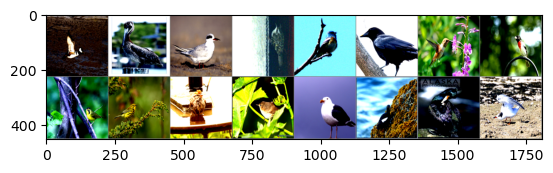

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


In [ ]:
#Step 2: Define a simple CNN model
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(16 * 64 * 64, num_classes)  # 16 channels * 64x64 image size
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
#net = SimpleCNN().to(device)
# Load a pretrained ResNet model
net = models.resnet18(pretrained=True)
net.to(device)

/Users/christinaperdue/anaconda3/envs/lab2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/christinaperdue/anaconda3/envs/lab2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
# Step 2.1: Initialize the model
print(net)

# Step 3: Define a loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for epoch in range(num_epochs):
    net.train()  # Set model to training mode
    running_loss = 0.0
    total = 0  # Initialize total for this epoch
    correct = 0  # Initialize correct for this epoch

    for images, labels in train_dataloader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)  # Adjust labels if 1-indexed

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss for display
        running_loss += loss.item()
        total += labels.size(0)
        batch_correct = (torch.argmax(outputs, 1) == labels).sum().item()  # Adjust for 1-indexed labels
        correct += batch_correct
    
    # Display epoch results
    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct / total * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch [1/20], Loss: 5.0420, Accuracy: 13.70%
Epoch [2/20], Loss: 1.6875, Accuracy: 62.20%
Epoch [3/20], Loss: 0.5275, Accuracy: 92.33%
Epoch [4/20], Loss: 0.1613, Accuracy: 99.34%
Epoch [5/20], Loss: 0.0669, Accuracy: 100.00%
Epoch [6/20], Loss: 0.0381, Accuracy: 100.00%
Epoch [7/20], Loss: 0.0265, Accuracy: 100.00%
Epoch [8/20], Loss: 0.0197, Accuracy: 100.00%
Epoch [9/20], Loss: 0.0148, Accuracy: 100.00%
Epoch [10/20], Loss: 0.0118, Accuracy: 100.00%
Epoch [11/20], Loss: 0.0098, Accuracy: 100.00%
Epoch [12/20], Loss: 0.0083, Accuracy: 100.00%
Epoch [13/20], Loss: 0.0071, Accuracy: 100.00%
Epoch [14/20], Loss: 0.0872, Accuracy: 98.19%
Epoch [15/20], Loss: 0.5452, Accuracy: 87.77%
Epoch [16/20], Loss: 0.0816, Accuracy: 98.90%
Epoch [17/20], Loss: 0.0213, Accuracy: 99.80%
Epoch [18/20], Loss: 0.0126, Accuracy: 99.85%
Epoch [19/20], Loss: 0.0102, Accuracy: 99.95%
Epoch [20/20], Loss: 0.0055, Accuracy: 100.00%


In [ ]:

net.eval()  # Set model to evaluation mode

predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:  # Assuming dataset includes image paths
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = net(images)
        
        # Get predictions (no need to subtract or add indices unless necessary)
        _, preds = torch.max(outputs, 1)
        
        # Append predictions to the list
        predictions.extend(preds.cpu().numpy())  # Convert to list and extend the predictions list
        #predictions.append((image, preds.item()))
        
        # Append original labels for analysis
        all_labels.extend(labels.cpu().tolist())  # Convert labels to list and extend

        

In [52]:
torch.save(net.state_dict(), "christinaperdue_net.pth")

In [53]:
#print(len(predictions[0]))
#final_labels = np.argmax(predictions, axis = 1)
#print(final_labels)
#df = pd.DataFrame(final_labels)
#df.value_counts()

#print(df.head())

print(all_labels)
df2 = pd.DataFrame(predictions, columns=['label'])
df2.index += 1  # Shift the index to start at 1
df2.to_csv("predictions.csv", index=True, index_label='id')
#df2 = pd.DataFrame(predictions, columns=['id', 'label'])
#df2.to_csv("predictions.csv", index=False)
print(df2.head())

[38, 33, 136, 42, 178, 12, 49, 17, 17, 25, 95, 82, 26, 111, 170, 189, 121, 138, 9, 187, 101, 16, 103, 55, 158, 95, 123, 139, 63, 35, 128, 78, 3, 85, 119, 63, 53, 48, 4, 54, 172, 132, 124, 127, 28, 15, 63, 110, 100, 49, 46, 88, 102, 98, 15, 57, 104, 39, 103, 14, 30, 72, 107, 73, 14, 42, 91, 1, 180, 87, 28, 40, 149, 65, 30, 8, 129, 63, 158, 48, 23, 81, 166, 52, 15, 100, 98, 59, 133, 6, 39, 21, 10, 13, 29, 9, 86, 105, 120, 161, 91, 62, 33, 22, 31, 173, 83, 38, 113, 33, 12, 127, 175, 37, 15, 168, 68, 64, 75, 156, 25, 36, 182, 102, 194, 37, 108, 20, 43, 74, 57, 38, 63, 45, 125, 4, 35, 100, 113, 131, 37, 27, 42, 3, 9, 31, 102, 77, 117, 106, 131, 61, 135, 81, 115, 115, 49, 149, 15, 178, 87, 56, 155, 120, 24, 76, 191, 21, 110, 196, 56, 30, 113, 14, 82, 73, 59, 79, 108, 26, 169, 91, 61, 95, 116, 77, 141, 38, 55, 83, 101, 94, 22, 140, 93, 26, 56, 26, 142, 159, 45, 157, 165, 34, 199, 8, 111, 156, 74, 47, 104, 34, 86, 62, 77, 83, 7, 25, 58, 3, 53, 16, 77, 26, 60, 44, 70, 45, 80, 109, 20, 14, 8, 36

In [ ]:
#NEED THIS FOR LIME
#  Save and load the model
# Save the model's state dictionary
#torch.save(net.state_dict(), "christinaperdue_net.pth")
#model = SimpleCNN()  # Replace `MyModel` with your model's class
#net.load_state_dict(torch.load('christinaperdue_net.pth'))
#model.eval()  # Set the model to evaluation mode if you're not training

In [110]:
from PIL import Image
import numpy as np
import torch

# torch.save(net.state_dict(), "christinaperdue_net.pth")
# model = models.resnet18(pretrained=True)

#lime_model = torch.load('christinaperdue_net.pth')
# Set the model to evaluation mode if you're not training


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
images, labels = images.to(device), labels.to(device)

if torch.cuda.is_available():
    net.cuda()


# Define preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure RGB format
    return preprocess(image).unsqueeze(0)  # Add batch dimension

# Training image (used during model training)
test_image_path = 'data/test_images/test_images/39.jpg'

# Use the test image for LIME
image_tensor = preprocess_image(test_image_path)
image_tensor = image_tensor.to(device)


In [111]:
def predict_fn(images):
    """
    LIME requires NumPy arrays as input. This function:
    1. Converts NumPy arrays to PyTorch tensors.
    2. Passes them through the model.
    3. Returns probabilities as a NumPy array.
    """
    # images_tensor = torch.from_numpy(images).permute(0, 3, 1, 2).float()  # Convert NHWC to NCHW
    # outputs = net(images_tensor)
    # probabilities = torch.nn.functional.softmax(outputs, dim=1).detach().numpy()
    # return probabilities

    # Define the class names# Convert inputs from numpy to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    # Move inputs to the same device as the model
    device = next(net.parameters()).device
    inputs = inputs.to(device)

    # Perform inference
    with torch.no_grad():
        logits = net(inputs)
        probs = F.softmax(logits, dim=1)
    
    # Convert predictions back to numpy
    return probs.cpu().numpy()


In [112]:
from lime.lime_image import LimeImageExplainer

explainer = LimeImageExplainer()

In [113]:
explanation = explainer.explain_instance(
    image=image_tensor.squeeze().permute(1, 2, 0).cpu().numpy(),  # Convert tensor to HWC NumPy array
    classifier_fn=predict_fn,  # The prediction function
    top_labels=5,  # Number of top labels to explain
    hide_color=0,  # Color for hidden regions
    num_samples=1000  # Number of perturbations
)

  0%|          | 0/1000 [00:00<?, ?it/s]

UnboundLocalError: cannot access local variable 'inputs' where it is not associated with a value

In [61]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Get the explanation for the top label
label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=label,
    positive_only=True,  # Show only positive contributions
    num_features=5,  # Number of superpixels to show
    hide_rest=False  # Whether to hide other parts of the image
)

# Plot the explanation
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"Explanation for Label: {label}")
plt.axis('off')
plt.show()

NameError: name 'explanation' is not defined